In [ ]:
import json
import pandas as pd
from mlinterpreter.util import preprocess_data
from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.heloc_dataset import HELOCDataset

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## load data

In [ ]:
import sys
sys.path.append('./')

In [ ]:
path = '.'

In [ ]:
# 读入数据 和 schema
data_path = f"{path}/demo_data/adult.data"
schema_path = f"{path}/demo_data/schema.json"
df = pd.read_csv(data_path, header=None)
df.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex",
                 "capital-gain","capital-loss","hours-per-week","native-country","income"]
with open(schema_path, "r") as f:
    schema = json.load(f)
    

## preprocess data

In [ ]:
# 预处理数据
preprocess_df, preprocess_dict = preprocess_data(df=df, schema=schema, process_label=True)

## build  LGBMClassifier

In [ ]:
from mlinterpreter.model.builder import  build_lgb

In [ ]:
import lightgbm

In [ ]:
from sklearn.model_selection import train_test_split
preprocess_train, preprocess_test = train_test_split(preprocess_df, test_size=0.2, random_state=42)

In [ ]:
# 构建 lgb模型
# 通过 params 参数修改模型超参数
lgbmodel = build_lgb(df=preprocess_train, schema=schema)

[1]	valid_0's auc: 0.86422	valid_0's binary_logloss: 0.522538
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's auc: 0.868021	valid_0's binary_logloss: 0.506099
[3]	valid_0's auc: 0.870721	valid_0's binary_logloss: 0.491626
[4]	valid_0's auc: 0.879585	valid_0's binary_logloss: 0.478813
[5]	valid_0's auc: 0.884997	valid_0's binary_logloss: 0.46721
[6]	valid_0's auc: 0.885266	valid_0's binary_logloss: 0.456864
[7]	valid_0's auc: 0.885525	valid_0's binary_logloss: 0.447374
[8]	valid_0's auc: 0.886591	valid_0's binary_logloss: 0.438625
[9]	valid_0's auc: 0.886884	valid_0's binary_logloss: 0.430728
[10]	valid_0's auc: 0.887579	valid_0's binary_logloss: 0.423253
[11]	valid_0's auc: 0.887713	valid_0's binary_logloss: 0.416657
[12]	valid_0's auc: 0.889677	valid_0's binary_logloss: 0.410297
[13]	valid_0's auc: 0.891367	valid_0's binary_logloss: 0.404392
[14]	valid_0's auc: 0.891302	valid_0's binary_logloss: 0.398936
Early stopping, best iteration is:
[13]	valid_0's auc:

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['education', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


## 全局代理模型

In [ ]:
from mlinterpreter.surrogate.global_model import SurrogateTree

In [ ]:
# 申明 SurrogateTree
tree = SurrogateTree(params={"max_depth":3})

In [ ]:
# fit the SurrogateTree with the model
# return with the R2 value
tree.surrogate(model=lgbmodel, df=df, schema=schema, preprocess_dict=preprocess_dict)

0.9006813011357001

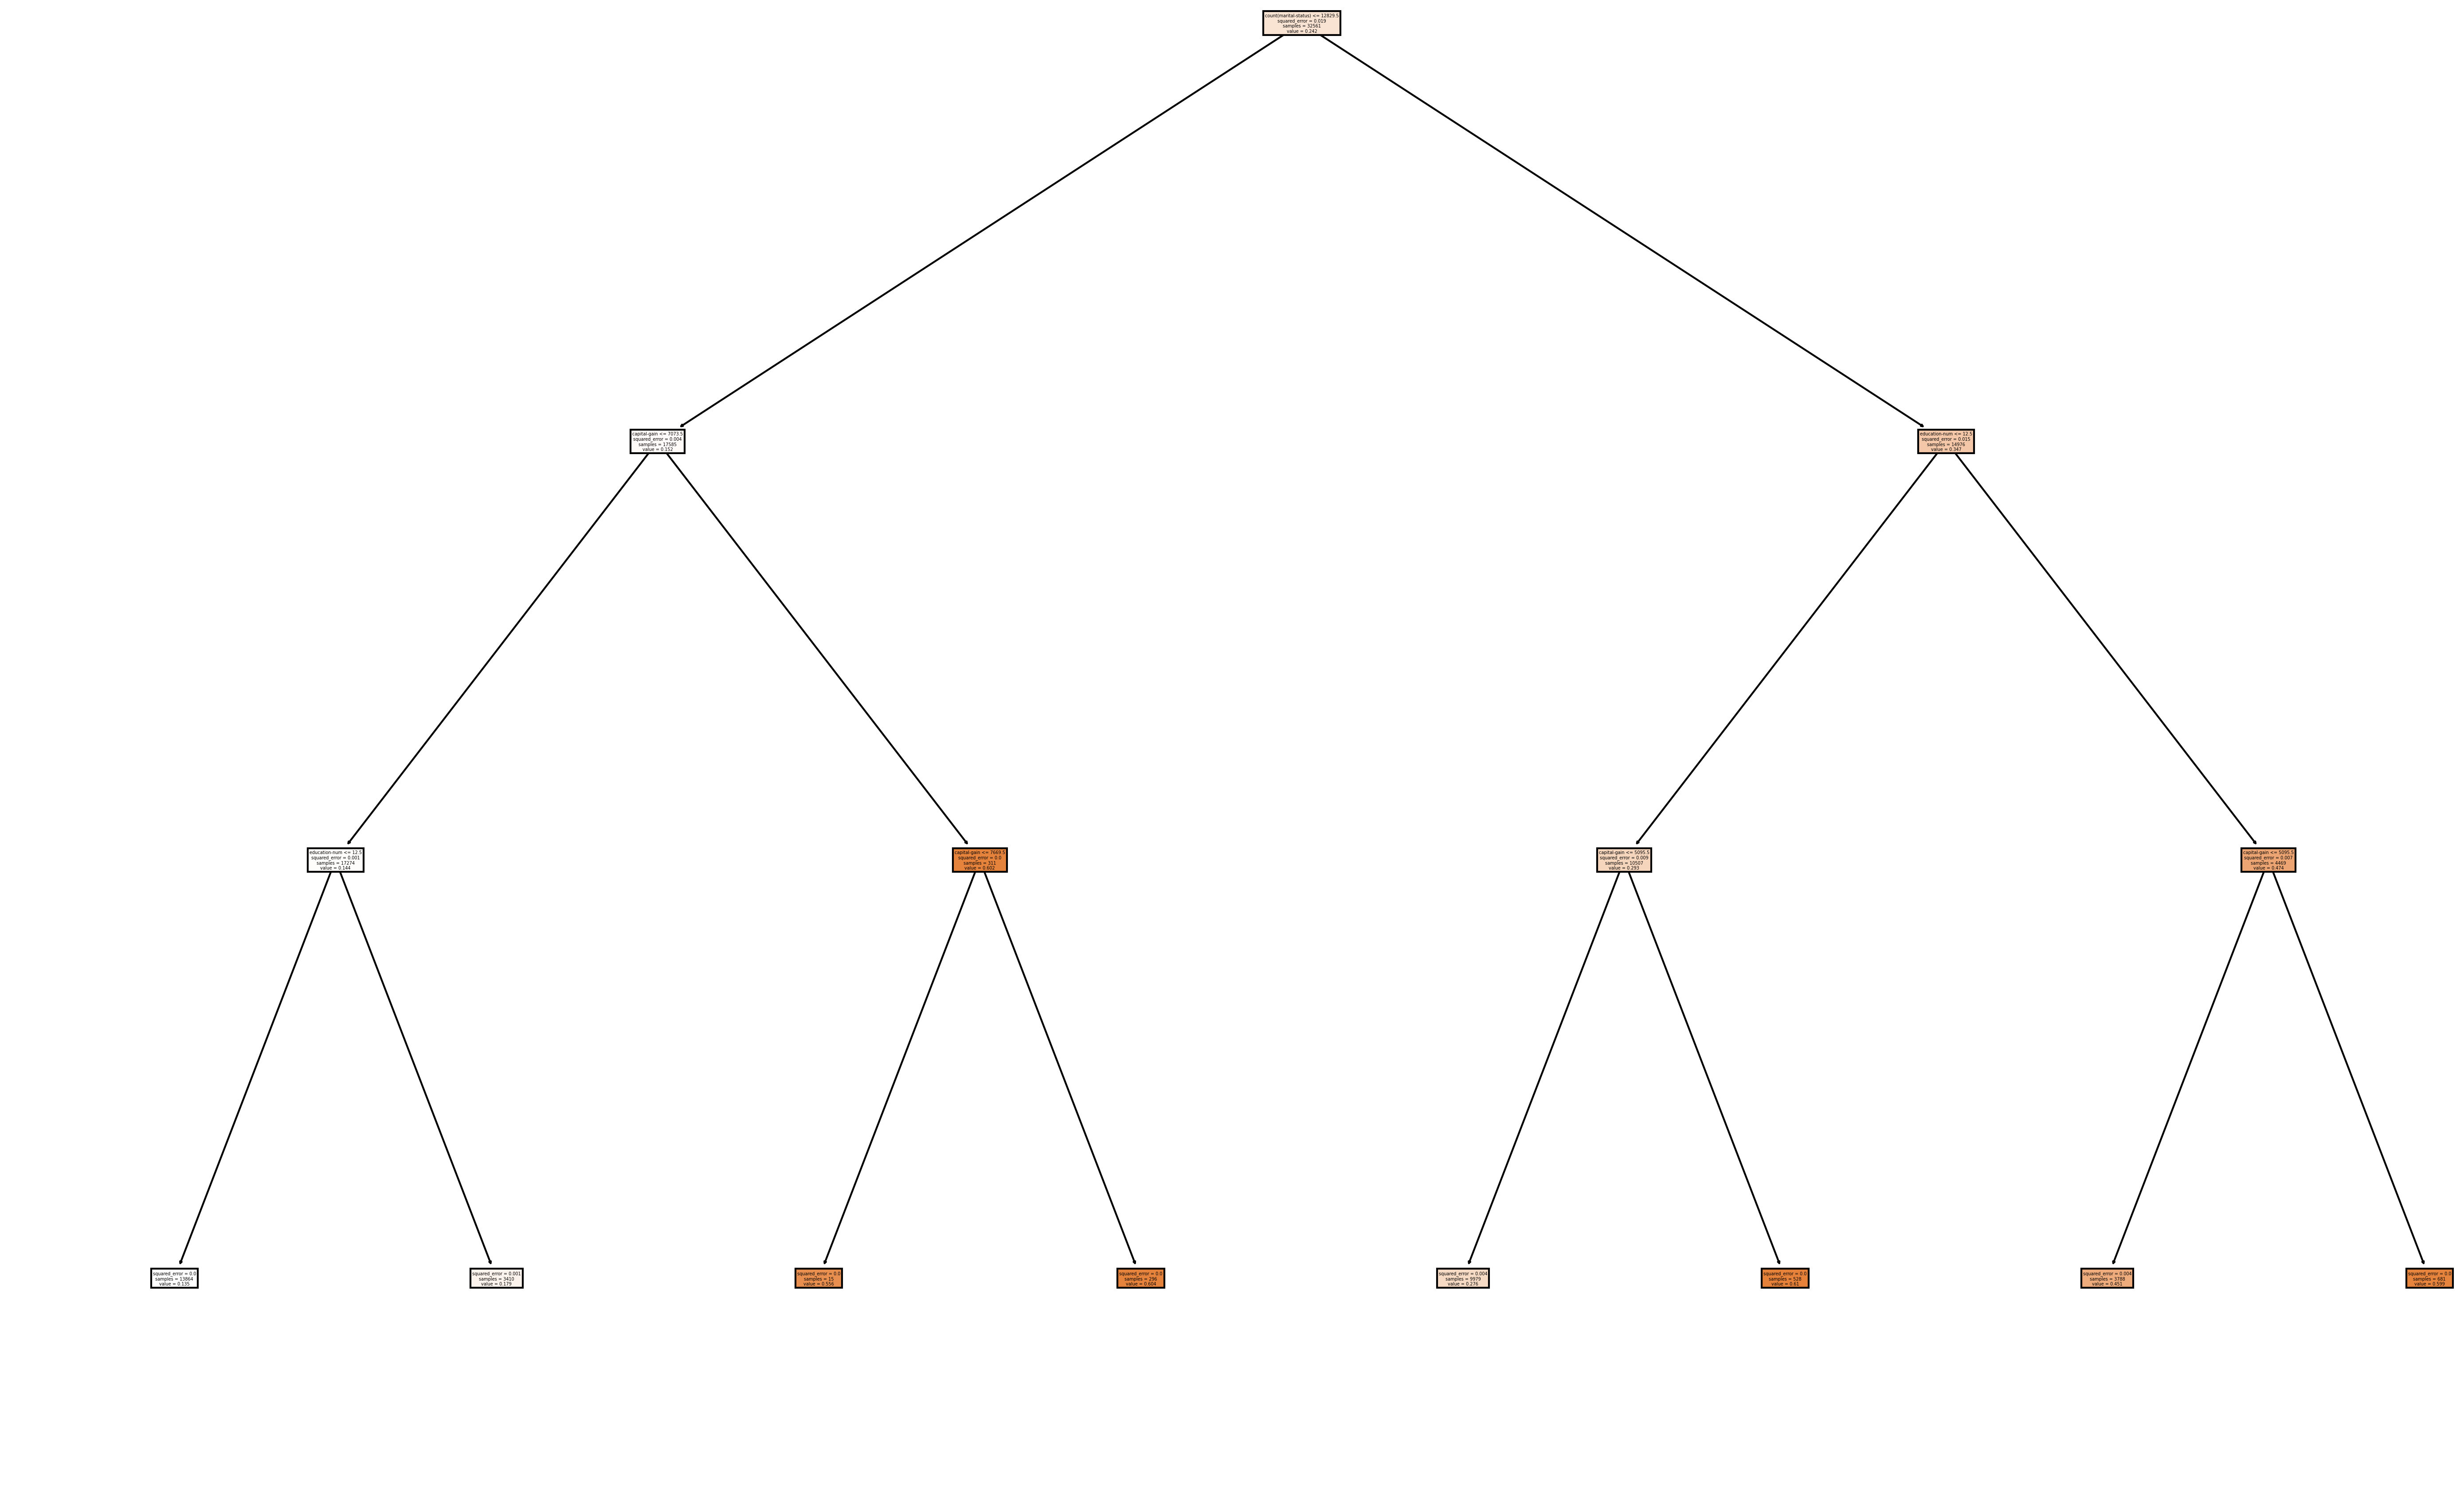

In [ ]:
# plot the SurrogateTree
tree.plot_tree()

## 局部代理模型

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# 生成解释器
feature_names = [fea['name'] for fea in schema['features'] if fea['name'] != schema['label']]
categorial_features = [fea['name'] for fea in schema['features'] if fea['name'] != schema['label'] and fea['type'] == 'Category']
X = preprocess_df[feature_names]


In [ ]:
import numpy as np

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X), feature_names=feature_names, 
                                                   categorical_features=categorial_features,
                                                   class_names=[0,1], discretize_continuous=True)

In [ ]:
# 对局部点的解释
i = np.random.randint(0, X.shape[0])
exp = explainer.explain_instance(np.array(X)[i], lgbmodel.predict_proba, num_features=6)

In [ ]:
# 显示详细信息图
exp.show_in_notebook(show_table=True)

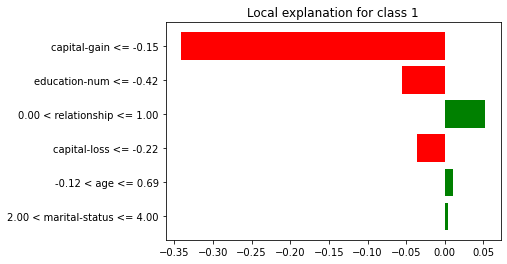

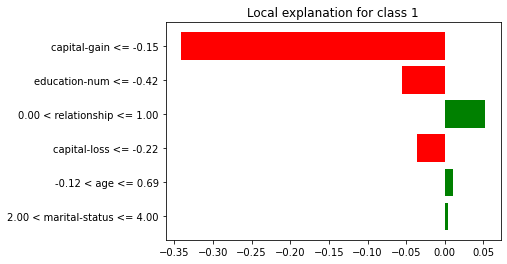

In [ ]:
# 显示权重图
exp.as_pyplot_figure()

## Shapley模型可解释功能

In [ ]:
from mlinterpreter.shap.shap import ShapInterpreter

In [ ]:
# 构建 interpreter
# model ： 待解释模型
# background_data: 背景数据
# schema : 数据schmea
# preprocess_dict: 预处理模块
interpreter = ShapInterpreter(model=lgbmodel, background_data=preprocess_df.sample(50), schema=schema, preprocess_dict=preprocess_dict)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


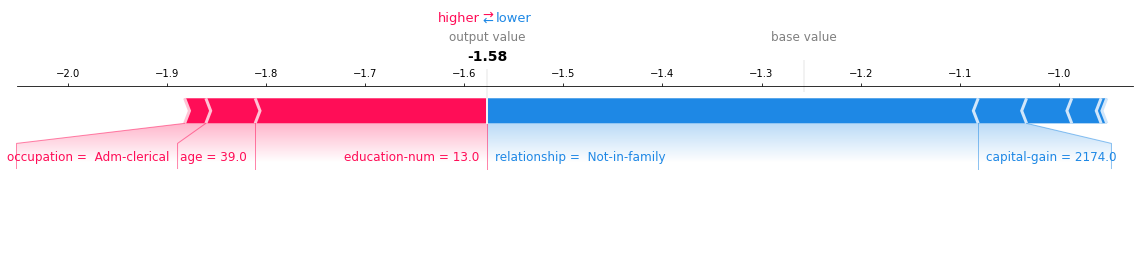

In [ ]:
# plot SHAP value for one point
interpreter.force_plot(df=df.iloc[0,:])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


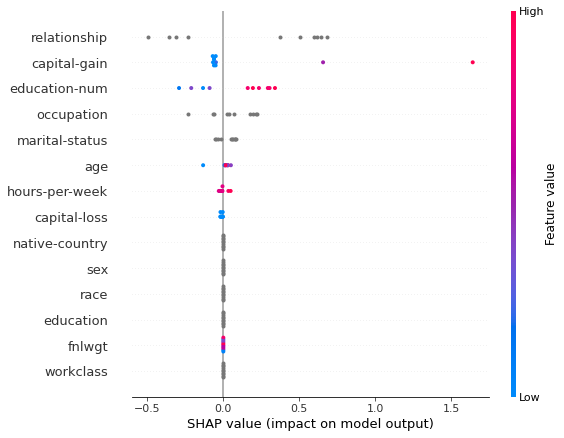

In [ ]:
# dot plot summary with several points
# nsample: 在计算SHAP value时用，采样次数
interpreter.summary_plot(df=df.iloc[0:10,:], nsamples=500)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


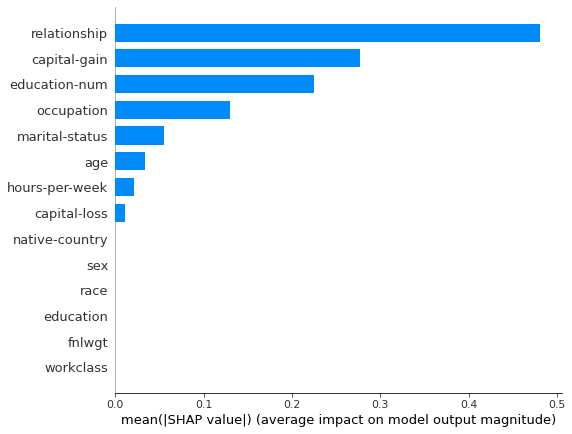

In [ ]:
# bar plot summary with several points
# nsample: 在计算SHAP value时用，采样次数
interpreter.summary_plot(df=df.iloc[0:10,:], nsamples=500, plot_type='bar')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


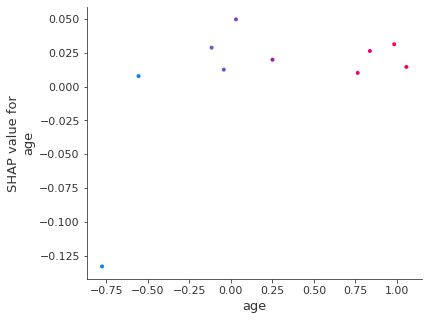

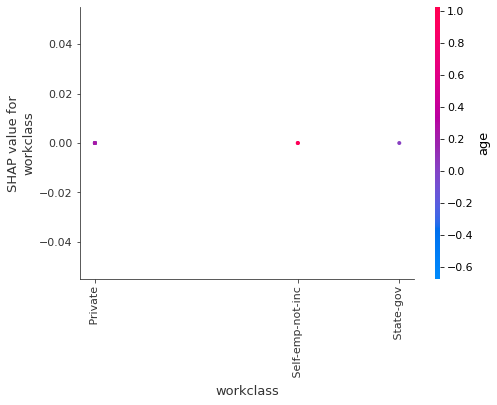

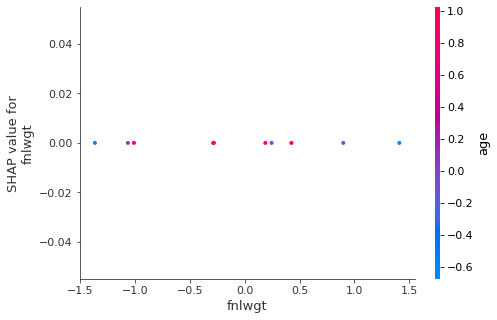

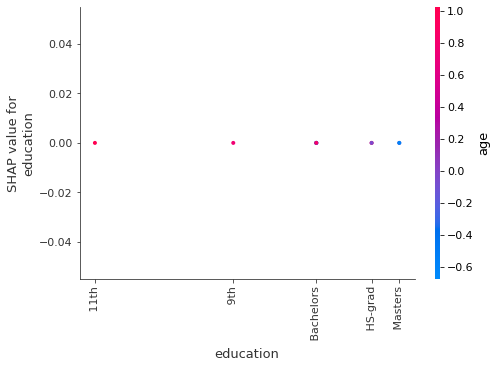

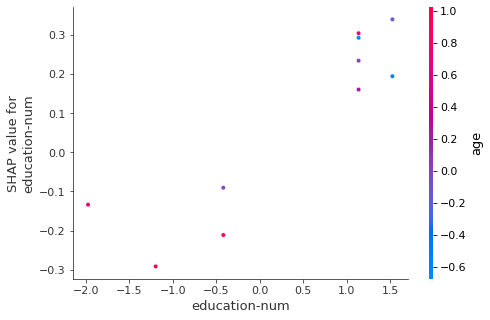

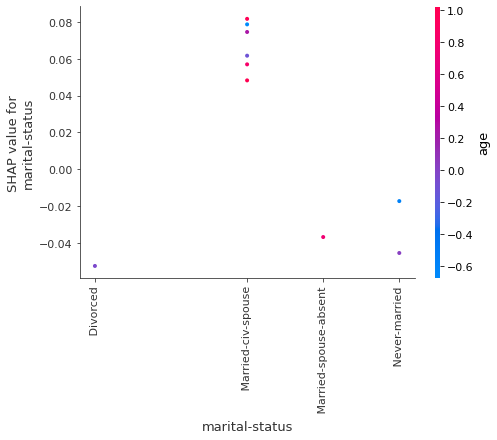

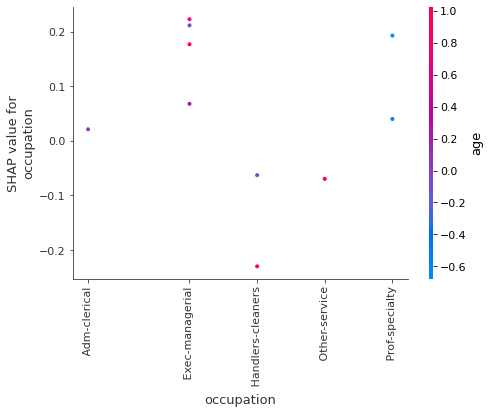

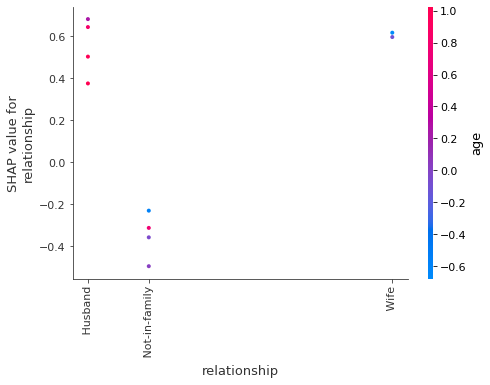

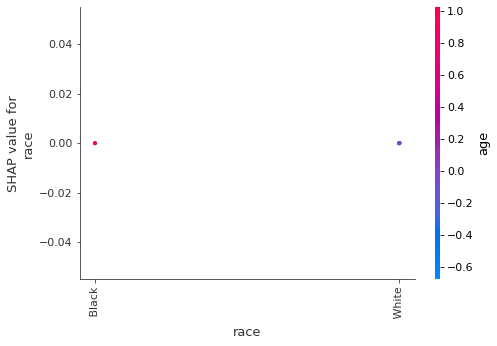

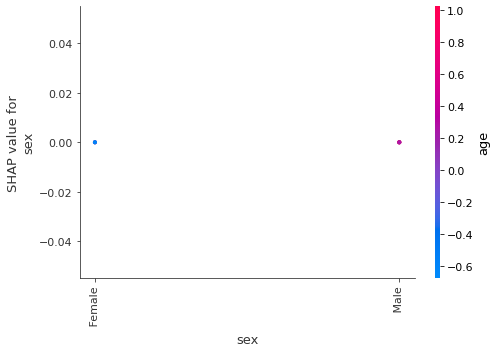

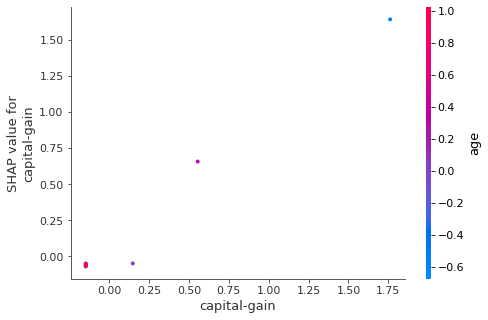

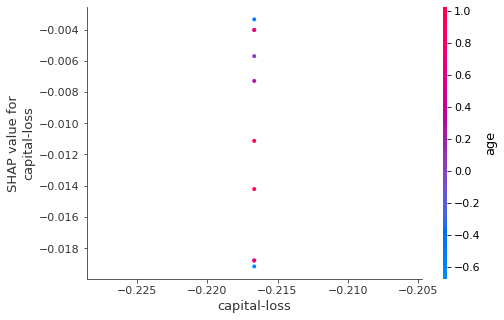

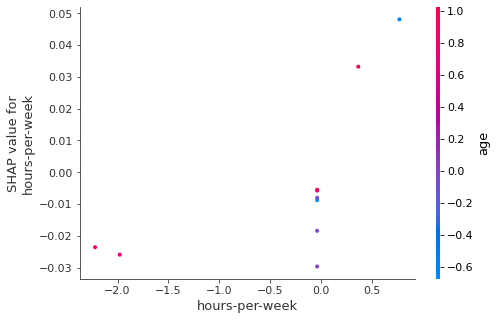

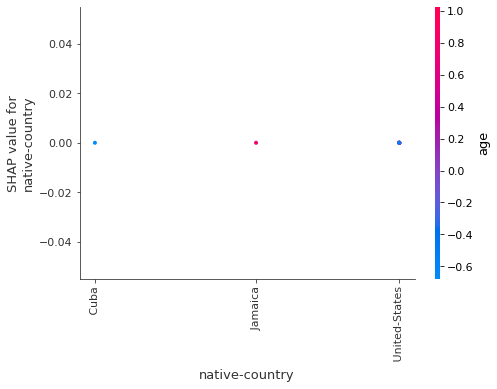

In [ ]:
# dependence plot with several points
# nsample: 在计算SHAP value时用，采样次数
# if feature_name is not given, we will plot for all the features
interpreter.dependence_plot(df=df.iloc[0:10,:], nsamples=500)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


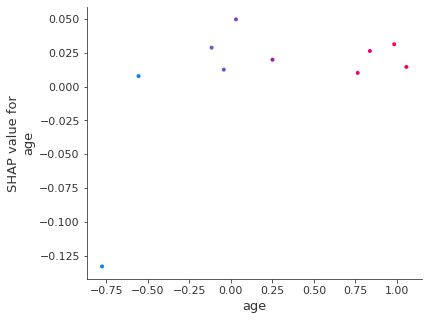

In [ ]:
# dependence plot with several points
# nsample: 在计算SHAP value时用，采样次数
# specify a feature
interpreter.dependence_plot(df=df.iloc[0:10,:], feature_name='age', nsamples=500)


## 代表性和非代表性样本可解释, Protodash

In [ ]:
target = 'income'
used = [x for x in df.columns if x != target]
X = preprocess_df[used]
y = preprocess_df[target]

In [ ]:
used = [x for x in df.columns if x != target]
from sklearn.model_selection import train_test_split

xn_train, xn_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=42)  # normalized data
x_train, x_test = train_test_split(df[used], test_size=0.2, random_state=42)
x_train.index = range(len(x_train))
x_test.index = range(len(x_test))

In [ ]:
p_train = lgbmodel.predict(xn_train) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]

zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]

In [ ]:
class_names = ['income<50', 'incode>=50']

In [ ]:
idx = 1

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
if lgbmodel.predict_proba(X)[0][1] <= 0.5:
  print("Prediction made by the model:", class_names[0])
else:
  print("Prediction made by the model:", class_names[1])
print("Prediction probabilities:", lgbmodel.predict_proba(X)[0][1])
print("")

# attach the prediction made by the model to X
X = np.hstack((X, lgbmodel.predict_proba(X)[0][1].reshape((1,1))))

Chosen Sample: 1
Prediction made by the model: income<50
Prediction probabilities: 0.3278512578523668



In [ ]:
x_test.iloc[idx]

age                                45
workclass                   State-gov
fnlwgt                          50567
education                     HS-grad
education-num                       9
marital-status     Married-civ-spouse
occupation            Exec-managerial
relationship                     Wife
race                            White
sex                            Female
capital-gain                        0
capital-loss                        0
hours-per-week                     40
native-country          United-States
Name: 1, dtype: object

In [ ]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1])
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names

In [ ]:
dfs[dfs.shape[1]+1] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

,0,1,2,3,4
age,53,31,52,36,35
workclass,State-gov,Private,Private,Self-emp-not-inc,Private
fnlwgt,281590,37546,84278,35945,44780
education,HS-grad,Bachelors,Some-college,7th-8th,Some-college
education-num,9,13,10,4,10
marital-status,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse
occupation,Exec-managerial,Exec-managerial,Exec-managerial,Machine-op-inspct,Adm-clerical
relationship,Wife,Wife,Husband,Husband,Wife
race,White,White,White,White,White
sex,Female,Female,Male,Male,Female


In [ ]:
z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()

,0,1,2,3,4
age,0.42,0.22,0.47,0.38,0.34
workclass,1.00,0.09,0.09,0.45,0.09
fnlwgt,0.09,0.87,0.70,0.86,0.94
education,1.00,0.59,0.35,0.21,0.35
education-num,1.00,0.25,0.71,0.18,0.71
marital-status,1.00,1.00,1.00,1.00,1.00
occupation,1.00,1.00,1.00,0.21,0.21
relationship,1.00,1.00,0.13,0.13,1.00
race,1.00,1.00,1.00,1.00,1.00
sex,1.00,1.00,0.13,0.13,1.00


In [ ]:
z_train_bad = z_train[z_train[:,-1]==0, :]
zun_train_bad = zun_train[zun_train[:,-1]==0, :]

In [ ]:
idx = 80

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
if lgbmodel.predict_proba(X)[0][1] <= 0.5:
  print("Prediction made by the model:", class_names[0])
else:
  print("Prediction made by the model:", class_names[1])
print("Prediction probabilities:", lgbmodel.predict_proba(X)[0][1])
print("")

# attach the prediction made by the model to X
X = np.hstack((X, lgbmodel.predict_proba(X)[0][1].reshape((1,1))))

Chosen Sample: 80
Prediction made by the model: incode>=50
Prediction probabilities: 0.604227986211746



In [ ]:
x_test.iloc[idx]

age                            29
workclass                 Private
fnlwgt                     152461
education               Bachelors
education-num                  13
marital-status      Never-married
occupation         Prof-specialty
relationship            Unmarried
race                        White
sex                        Female
capital-gain                14344
capital-loss                    0
hours-per-week                 50
native-country      United-States
Name: 80, dtype: object

In [ ]:
(W, S, setValues) = explainer.explain(X, z_train_bad, m=5) # Return weights W, Prototypes S and objective function values

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
# move samples to a dataframe to display
dfs = pd.DataFrame.from_records(zun_train_bad[S, 0:-1])
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_bad[S[i], -1])]) # Append class names
dfs[dfs.shape[1]+1] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Compute normalized importance weights for prototypes
dfs.transpose()

,0,1,2,3,4
age,24,90,35,30,39
workclass,Private,Private,?,Self-emp-not-inc,Federal-gov
fnlwgt,187937,90523,164866,67072,193583
education,Bachelors,HS-grad,10th,Bachelors,Bachelors
education-num,13,9,6,13,13
marital-status,Never-married,Widowed,Divorced,Married-spouse-absent,Divorced
occupation,Prof-specialty,Transport-moving,?,Craft-repair,Prof-specialty
relationship,Unmarried,Unmarried,Not-in-family,Not-in-family,Unmarried
race,White,White,White,White,White
sex,Female,Male,Male,Male,Female


In [ ]:
z = z_train_bad[S, 0:-1] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()

,0,1,2,3,4
age,0.81,0.08,0.78,0.96,0.66
workclass,1.00,1.00,0.16,0.40,0.25
fnlwgt,0.51,0.30,0.79,0.19,0.45
education,1.00,0.60,0.10,1.00,1.00
education-num,1.00,0.25,0.09,1.00,1.00
marital-status,1.00,0.42,0.18,0.65,0.18
occupation,1.00,0.46,0.14,0.25,1.00
relationship,1.00,1.00,0.13,0.13,1.00
race,1.00,1.00,1.00,1.00,1.00
sex,1.00,0.13,0.13,0.13,1.00
